Solar Power Forecasting Using Feed Forward Neural Network
==================================================

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_logarithmic_error
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers

sns.set()
print(datetime(2011,1,3,0,0))

Using TensorFlow backend.


2011-01-03 00:00:00


## Data Preprocessing
   Taking data from 08:00:00 to 18:00:00

In [2]:
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H %M')
def prepro_data(data,start,end):
    data.index.name='date'
    data = data.drop(['DHI','DNI','Clearsky DHI','Clearsky DNI','Clearsky GHI','Precipitable Water','Fill Flag','Cloud Type'],axis = 1)
    data = data.iloc[:,:8]
    data.columns = ['ghi', 'dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd']
    data = data[['dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd','ghi']]
    # data = data[data.ghi != 0]
    data = data.between_time(start, end)
    scaler = MinMaxScaler(feature_range=(0,1))
    data = pd.DataFrame(scaler.fit_transform(data))
    data.columns = ['dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd','ghi']
    print(data.head())
    return data
start = '08:00:00'
end  = '18:00:00'

### Training Data

In [3]:
df_train =pd.read_csv('full_data.csv',skiprows=2, parse_dates =[['Year','Month','Day','Hour','Minute']], 
                      index_col=0, date_parser=parse)
df_train = prepro_data(df_train,start,end)

        dew      temp     press  rel_humid  zenith_ang   wnd_dir   wnd_spd  \
0  0.509344  0.158706  0.669688   0.735891    0.834764  0.142178  0.410248   
1  0.497932  0.190777  0.667440   0.618531    0.776134  0.142178  0.419865   
2  0.486023  0.222849  0.665189   0.519343    0.720894  0.145238  0.429481   
3  0.473727  0.250591  0.655385   0.442999    0.669818  0.145238  0.431609   
4  0.460853  0.278332  0.645580   0.377104    0.623834  0.143316  0.433736   

        ghi  
0  0.041446  
1  0.086420  
2  0.076720  
3  0.127866  
4  0.155203  


### Test Data

In [4]:
#test data
df_test =pd.read_csv('data-2014.csv',skiprows=2, parse_dates =[['Year','Month','Day','Hour','Minute']], 
                     index_col=0, date_parser=parse)
df_test = prepro_data(df_test,start,end)

        dew      temp     press  rel_humid  zenith_ang   wnd_dir   wnd_spd  \
0  0.421816  0.204787  0.682392   0.353138    0.834665  0.096198  0.312420   
1  0.418294  0.247065  0.694951   0.307383    0.776058  0.096198  0.293857   
2  0.414696  0.289343  0.707510   0.267708    0.720844  0.103307  0.275293   
3  0.415802  0.338519  0.704044   0.232698    0.669799  0.103307  0.267827   
4  0.416818  0.387693  0.700574   0.202426    0.623850  0.067208  0.260362   

        ghi  
0  0.080674  
1  0.167553  
2  0.255319  
3  0.337766  
4  0.410461  


## Plotting the training dataset

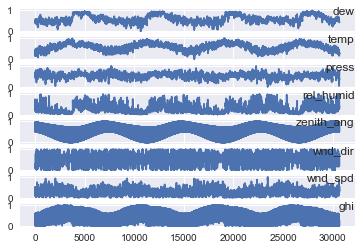

In [6]:
values=df_train.values
plt.figure()
for i in range(1,9):
    plt.subplot(8,1,i)
    plt.plot(values[:,i-1])
    plt.title(df_train.columns[i-1],y=.5,loc='right')
plt.show()

## Adding lag values in dataset

In [7]:
def series_to_supervised(data, dropnan=True):
    print(data.shape)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    v=list(df.values)
    #print(v[-1])
    ghi_col=['ghi(t)']
    ghi=df.filter(['ghi'],axis=1)
    ghi.cloumns=ghi_col
    df=df.drop('ghi',1)
    orig=df.columns
    print(ghi.columns)
    cols, names = list(), list()
    df=df.shift(1)
    n_col=[]
    for i in orig:
        n_col += [('%s(t-1)' % (i))]
    df.columns=n_col
    # input sequence (t-n, ... t-1)
    time_steps=[1,2,3,21,22,23,42,43,44,147,148,149,294,295,296]
    for i in time_steps:
        cols.append(ghi.shift(i))
        names += [('%s(t-%d)' % ('ghi', i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    df=pd.concat([df,agg,ghi],axis=1)
    df.dropna(inplace=True)
    print(df.shape)
    return df

In [8]:
df_train=series_to_supervised(df_train)
df_train.head()

(30681, 8)
Index(['ghi'], dtype='object')
(30385, 23)


,dew(t-1),temp(t-1),press(t-1),rel_humid(t-1),zenith_ang(t-1),wnd_dir(t-1),wnd_spd(t-1),ghi(t-1),ghi(t-2),ghi(t-3),...,ghi(t-42),ghi(t-43),ghi(t-44),ghi(t-147),ghi(t-148),ghi(t-149),ghi(t-294),ghi(t-295),ghi(t-296),ghi
296,0.300273,0.144648,0.738298,0.307997,0.773388,0.100712,0.543144,0.179012,0.086420,0.000000,...,0.269841,0.178131,0.085538,0.253968,0.165785,0.077601,0.076720,0.086420,0.041446,0.271605
297,0.289659,0.170548,0.746971,0.263945,0.716325,0.099846,0.565375,0.271605,0.179012,0.086420,...,0.357143,0.269841,0.178131,0.338624,0.253968,0.165785,0.127866,0.076720,0.086420,0.358907
298,0.275634,0.192180,0.749840,0.226367,0.663197,0.099846,0.574697,0.358907,0.271605,0.179012,...,0.434744,0.357143,0.269841,0.413580,0.338624,0.253968,0.155203,0.127866,0.076720,0.437390
299,0.260756,0.213813,0.752712,0.193224,0.614930,0.092990,0.584019,0.437390,0.358907,0.271605,...,0.500882,0.434744,0.357143,0.478836,0.413580,0.338624,0.239859,0.155203,0.127866,0.505291
300,0.248771,0.230751,0.739896,0.170317,0.572623,0.092990,0.588796,0.505291,0.437390,0.358907,...,0.553792,0.500882,0.434744,0.531746,0.478836,0.413580,0.241623,0.239859,0.155203,0.559083


In [9]:
df_test=series_to_supervised(df_test)
df_test.head()

(7665, 8)
Index(['ghi'], dtype='object')
(7369, 23)


,dew(t-1),temp(t-1),press(t-1),rel_humid(t-1),zenith_ang(t-1),wnd_dir(t-1),wnd_spd(t-1),ghi(t-1),ghi(t-2),ghi(t-3),...,ghi(t-42),ghi(t-43),ghi(t-44),ghi(t-147),ghi(t-148),ghi(t-149),ghi(t-294),ghi(t-295),ghi(t-296),ghi
296,0.362721,0.204074,0.949217,0.284527,0.773533,0.202716,0.560896,0.179965,0.086879,0.000000,...,0.272163,0.179078,0.085993,0.251773,0.164007,0.078014,0.255319,0.167553,0.080674,0.273050
297,0.370293,0.257400,0.951337,0.249402,0.716506,0.205686,0.533340,0.273050,0.179965,0.086879,...,0.359043,0.272163,0.179078,0.335106,0.251773,0.164007,0.337766,0.255319,0.167553,0.359929
298,0.359342,0.309000,0.943784,0.205122,0.663418,0.205686,0.552627,0.359929,0.273050,0.179965,...,0.437943,0.359043,0.272163,0.409574,0.335106,0.251773,0.410461,0.337766,0.255319,0.438830
299,0.347968,0.360599,0.936231,0.168389,0.615196,0.206624,0.571915,0.438830,0.359929,0.273050,...,0.504433,0.437943,0.359043,0.473404,0.409574,0.335106,0.473404,0.410461,0.337766,0.506206
300,0.344952,0.394411,0.904791,0.150522,0.572936,0.206624,0.546698,0.506206,0.438830,0.359929,...,0.557624,0.504433,0.437943,0.524823,0.473404,0.409574,0.523050,0.473404,0.410461,0.561170


## Splitting dataset into train and test set 

In [10]:
train = df_train.values
test = df_test.values
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

## Model Architecture

In [16]:
model=Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(16,activation = 'relu'))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
model.add(Dense(64,input_dim=train_X.shape[1],activation='relu'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='tanh'))
model.add(Dense(1,activation='relu'))
optimizer=optimizers.Adam(lr=1e-7,beta_1=0.9, beta_2=0.999, epsilon=None)
model.compile(loss=mean_squared_logarithmic_error, optimizer='adam',metrics=['mean_squared_error'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1472      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


## Fitting the model and plotting the train and test error

Train on 30385 samples, validate on 7369 samples
Epoch 1/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0037 - val_mean_squared_error: 0.0075
Epoch 2/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0037 - val_mean_squared_error: 0.0075
Epoch 3/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0036 - val_mean_squared_error: 0.0074
Epoch 4/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0037 - val_mean_squared_error: 0.0075
Epoch 5/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0036 - val_mean_squared_error: 0.0074
Epoch 6/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0036 - val_mean_squared_error: 0.0074
Epoch 7/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0036 - val_mean_squared_error: 0.0074
Epoch 8/100
 - 1s - loss: 0.0032 - mean_squared_error: 0.0062 - val_loss: 0.0036 - val_mean_squared_error: 0.0074
Epoch 9/100
 - 1s - loss: 0.0032 - mean

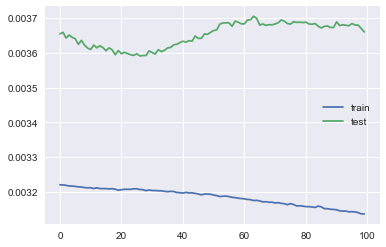

In [21]:
# fit network
history = model.fit(train_X, train_y, epochs=100,batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Model Evaluation

In [18]:
preds = model.predict(test_X, batch_size=128, verbose=2)

In [19]:
scores = model.evaluate(test_X, test_y, batch_size=128, verbose=2)
print(scores)

[0.003650780666111097, 0.0074619953404796826]


## Comparing Results

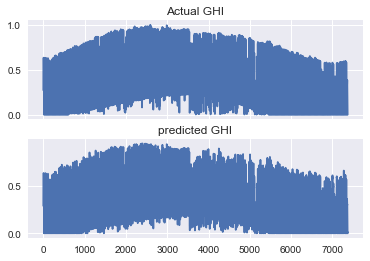

In [20]:
# plt.plot(test_y)
# plt.title('Actual GHI')
# plt.show()
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(test_y)
axarr[0].set_title('Actual GHI')

axarr[1].plot(preds)
axarr[1].set_title('predicted GHI')

plt.show()